##                Mask Rcnn using resnet-50 fpn as backbone

### Let us load the dataset first. We will be using the PennFudan Pedestrian detection dataset

In [1]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2020-01-04 17:45:35--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   933KB/s    in 52s     

2020-01-04 17:46:27 (1015 KB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-01-04 17:46:27--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-01-04 17:46:27--
Total wall clock time: 52s
Downloaded: 1 files, 51M in 52s (1015 KB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

Lets look at a single image from the dataset

In [0]:
from PIL import Image
#Image.open('PennFudanPed/PNGImages/.png')

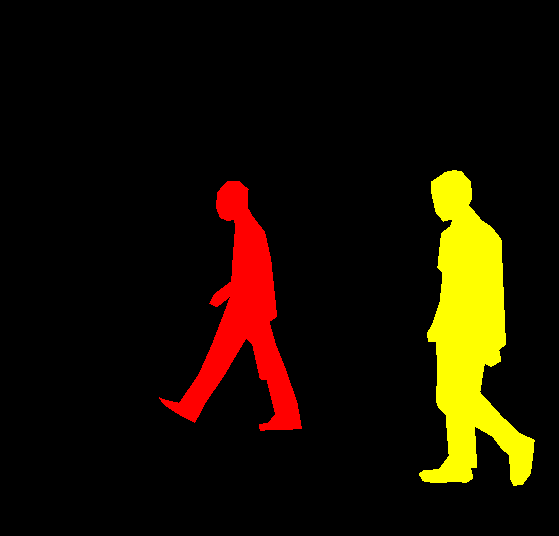

In [3]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F2AA7731898>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 6181 (delta 0), reused 2 (delta 0), pack-reused 6171
Receiving objects: 100% (6181/6181), 9.61 MiB | 2.17 MiB/s, done.
Resolving deltas: 100% (4121/4121), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


In [0]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    

Epoch: [0]  [  0/120]  eta: 0:03:24  lr: 0.000047  loss: 3.5042 (3.5042)  loss_classifier: 0.7939 (0.7939)  loss_box_reg: 0.0778 (0.0778)  loss_mask: 2.6120 (2.6120)  loss_objectness: 0.0155 (0.0155)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.7076  data: 0.2408  max mem: 1113
Epoch: [0]  [ 10/120]  eta: 0:00:54  lr: 0.000467  loss: 1.9299 (2.3072)  loss_classifier: 0.5695 (0.5383)  loss_box_reg: 0.1410 (0.1626)  loss_mask: 1.4277 (1.5799)  loss_objectness: 0.0141 (0.0185)  loss_rpn_box_reg: 0.0050 (0.0079)  time: 0.4950  data: 0.0254  max mem: 1686
Epoch: [0]  [ 20/120]  eta: 0:00:44  lr: 0.000886  loss: 1.1243 (1.6004)  loss_classifier: 0.3408 (0.3951)  loss_box_reg: 0.1619 (0.1847)  loss_mask: 0.5506 (0.9813)  loss_objectness: 0.0223 (0.0276)  loss_rpn_box_reg: 0.0080 (0.0117)  time: 0.3834  data: 0.0038  max mem: 1695
Epoch: [0]  [ 30/120]  eta: 0:00:38  lr: 0.001306  loss: 0.5802 (1.2441)  loss_classifier: 0.1285 (0.3058)  loss_box_reg: 0.1452 (0.1732)  loss_mask: 0.2511 (0.7309) 

In [16]:
# pick one image from the test set
img, tar = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([mytp.to(device)])
img

tensor([[[0.0588, 0.0627, 0.0627,  ..., 0.1294, 0.1725, 0.2118],
         [0.0588, 0.0627, 0.0588,  ..., 0.1608, 0.2471, 0.3176],
         [0.0588, 0.0588, 0.0549,  ..., 0.1216, 0.1961, 0.2314],
         ...,
         [0.8157, 0.8118, 0.8039,  ..., 0.8392, 0.8431, 0.8471],
         [0.8431, 0.8510, 0.8549,  ..., 0.8588, 0.8627, 0.8667],
         [0.8667, 0.8745, 0.8902,  ..., 0.8784, 0.8784, 0.8824]],

        [[0.0784, 0.0824, 0.0824,  ..., 0.1765, 0.2275, 0.2667],
         [0.0784, 0.0824, 0.0784,  ..., 0.2078, 0.3020, 0.3725],
         [0.0784, 0.0784, 0.0745,  ..., 0.1725, 0.2510, 0.2863],
         ...,
         [0.7098, 0.7059, 0.6902,  ..., 0.7647, 0.7686, 0.7725],
         [0.7529, 0.7490, 0.7490,  ..., 0.7843, 0.7882, 0.7922],
         [0.7843, 0.7922, 0.8000,  ..., 0.7961, 0.8039, 0.8078]],

        [[0.0627, 0.0667, 0.0667,  ..., 0.0902, 0.1294, 0.1686],
         [0.0627, 0.0667, 0.0627,  ..., 0.1216, 0.2118, 0.2745],
         [0.0627, 0.0627, 0.0588,  ..., 0.0941, 0.1608, 0.

In [14]:
myimg = Image.open('/content/lafi.png')
mytp = torchvision.transforms.ToTensor()( myimg)
mytp

tensor([[[0.5412, 0.5529, 0.5020,  ..., 0.7373, 0.7059, 0.7882],
         [0.5490, 0.5647, 0.5843,  ..., 0.7608, 0.7529, 0.7216],
         [0.5216, 0.5725, 0.5686,  ..., 0.7647, 0.7412, 0.7451],
         ...,
         [0.1451, 0.1333, 0.1333,  ..., 0.8275, 0.8157, 0.8000],
         [0.1176, 0.1490, 0.1333,  ..., 0.8157, 0.8941, 0.8314],
         [0.1255, 0.1255, 0.1490,  ..., 0.8745, 0.8471, 0.8510]],

        [[0.5137, 0.5333, 0.4941,  ..., 0.7765, 0.7451, 0.8275],
         [0.5216, 0.5451, 0.5804,  ..., 0.8000, 0.7922, 0.7608],
         [0.5098, 0.5608, 0.5608,  ..., 0.8039, 0.7804, 0.7843],
         ...,
         [0.1451, 0.1333, 0.1333,  ..., 0.8784, 0.8745, 0.8549],
         [0.1137, 0.1451, 0.1294,  ..., 0.8745, 0.9529, 0.8902],
         [0.1255, 0.1255, 0.1490,  ..., 0.9255, 0.9020, 0.9059]],

        [[0.4510, 0.4588, 0.4118,  ..., 0.7843, 0.7529, 0.8353],
         [0.4510, 0.4706, 0.4980,  ..., 0.8078, 0.8000, 0.7686],
         [0.4353, 0.4863, 0.4784,  ..., 0.8118, 0.7882, 0.

In [15]:
mytp.size()

torch.Size([3, 600, 800])

#### Lets inspect the Structure of target

In [0]:
tar

In [17]:
prediction

[{'boxes': tensor([[173.9110, 122.1021, 461.1167, 561.3844],
          [462.4305, 136.8759, 613.1755, 573.6816],
          [611.2411, 271.5051, 748.5251, 496.1974],
          [110.1472, 290.5960, 220.0559, 449.4792]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0.,

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

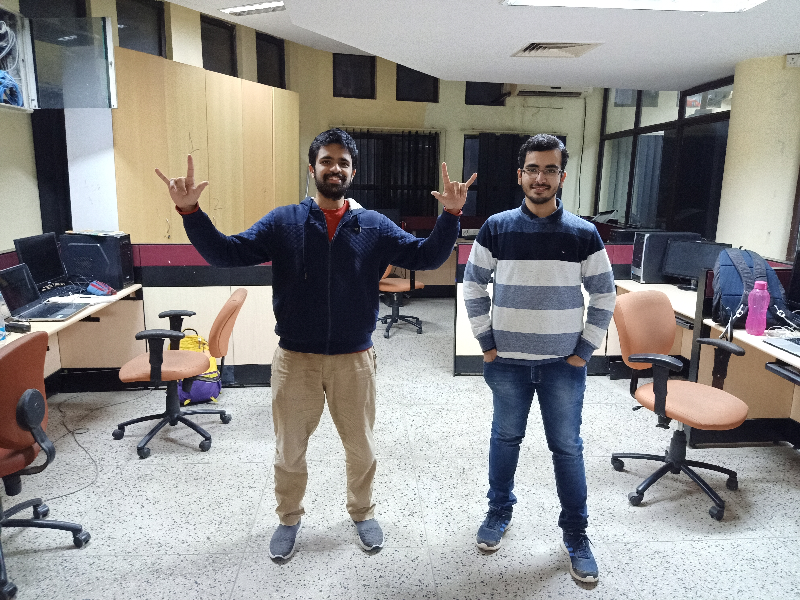

In [19]:
Image.fromarray(mytp.mul(255).permute(1,2,0).byte().numpy())

In [0]:
plt.imshow(Image.fromarray(tar['masks'][3].mul(255).byte().numpy()))
M = tar['masks'].size()[0]


In [0]:
Image.fromarray(mytp.mul(255).permute(1,2,0).byte().numpy())

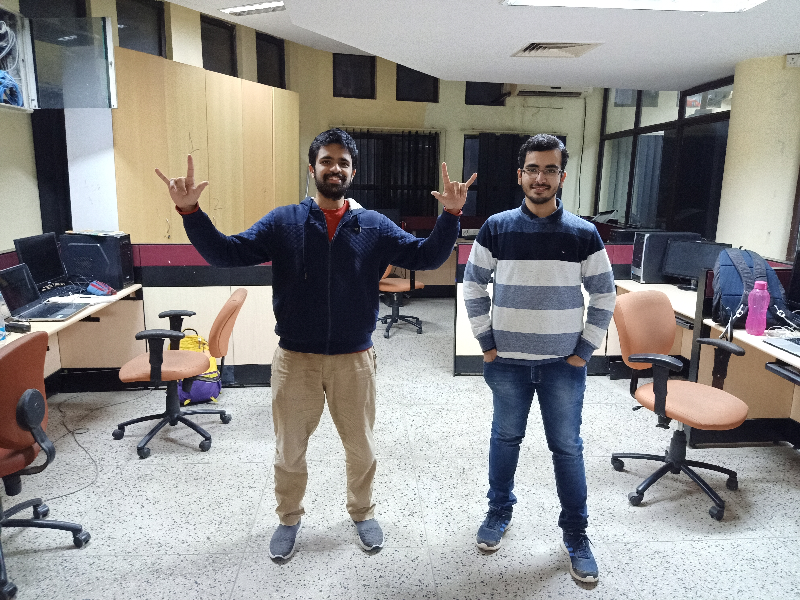

In [20]:
Image.fromarray(mytp.mul(255).permute(1,2,0).byte().numpy())

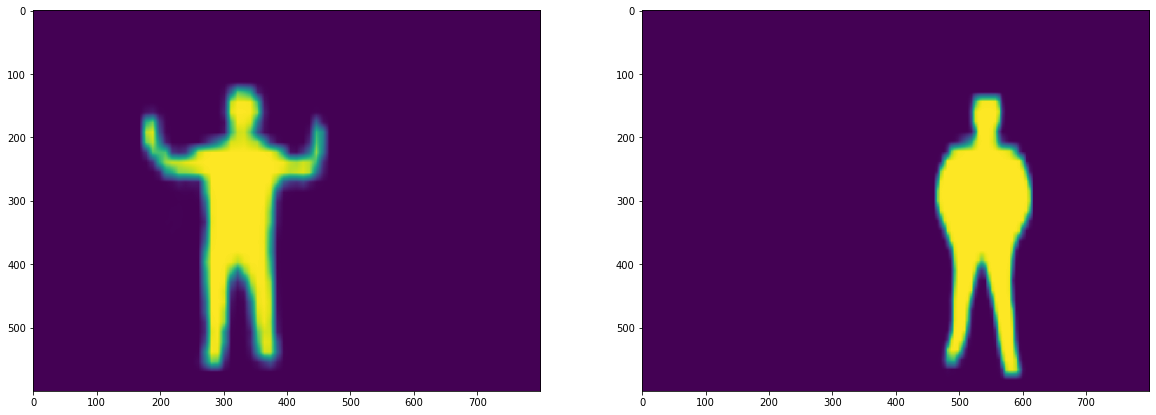

In [21]:
fig, (axs1) = plt.subplots(1,2,figsize= (20,20))
for i in range(2):
  #axs1[i].imshow(Image.fromarray(tar['masks'][i].mul(255).byte().numpy()))
  axs1[i].imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))

In [0]:
plt.imshow(Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy()))